# Core Features 

| Feature | What it measures | Units | Source (API/ticker/series) | Native frequency | Release/settle timing (ET) |
|---|---|---|---|---|---|
| Date | Trading day the observations refer to (EOD) | — | Derived index | Daily (US business days) | — |
| wti_price | WTI crude oil front‑month futures price (continuous prompt) | USD per barrel | Yahoo Finance: CL=F (Adj Close) | Daily trading days | Official settle ~2:30 pm ET |
| brent_price | Brent crude oil front‑month futures price (continuous prompt) | USD per barrel | Yahoo Finance: BZ=F (Adj Close) | Daily trading days | ~2:30 pm ET |
| dxy | US Dollar Index (futures proxy) | Index points | Yahoo Finance: DX=F | Daily trading days (nearly 24h) | Futures EOD mark |
| 10y_yield | US 10‑year Treasury yield | Percent (%) | Yahoo: ^TNX (÷10) or FRED: DGS10 | Daily (market days) | Close ~4:00 pm ET |
| vix | CBOE Volatility Index (implied 30‑day SPX vol) | Index points | Yahoo Finance: ^VIX | Daily (market days) | Close ~4:00 pm ET |
| eia_inventories | US crude oil ending stocks (excluding SPR) | Thousand barrels | EIA API v2 seriesid: PET.WCESTUS1.W | Weekly | Wed 10:30 am ET (Thu after Mon/Tue holiday) |
| cpi | US Consumer Price Index (headline, NSA) | Index (1982–84=100) | FRED: CPIAUCSL | Monthly | Mid‑month (prior month), 8:30 am ET |
| industrial_production | US Industrial Production index | Index (2017=100) | FRED: INDPRO | Monthly | Mid‑month (prior month), ~9:15 am ET |

In [1]:
import os
import json
import numpy as np
import pandas as pd
import yfinance as yf
import requests
from pandas_datareader import data as pdr
from holidays import UnitedStates
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

In [2]:
def _dbg_series(s: pd.Series, name: str, n: int = 3) :
    try:
        total = int(s.size)
        non_na = int(s.notna().sum()) if total else 0
        share = float(s.notna().mean()) if total else 0.0
        rng_min = str(s.dropna().index.min()) if non_na else "NA"
        rng_max = str(s.dropna().index.max()) if non_na else "NA"
        print(
            f"[DBG] {name}: non-NaN {non_na}/{total} "
            f"({share:.1%}), range [{rng_min} .. {rng_max}]"
        )
        if non_na:
            print(f"[DBG] {name} head:\n{s.dropna().head(n)}")
            print(f"[DBG] {name} tail:\n{s.dropna().tail(n)}")
    except Exception as e:
        print(f"[DBG] _dbg_series error for {name}: {e}")

# EIA weekly series helpers

In [3]:
def eia_fetch_weekly_series_v2(series_id: str, api_key: str) :
    """
    Fetch an EIA series using the v2 back-compat endpoint:
    /v2/seriesid/{V1_SERIES_ID}?api_key=...
    Returns a pandas Series indexed by the EIA 'period' dates.
    """
    print(f"[INFO] Requesting EIA v2 series '{series_id}' ...")
    url = f"https://api.eia.gov/v2/seriesid/{series_id}"
    params = {"api_key": api_key}
    print("[DBG] EIA GET", url, "params=api_key")
    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    j = r.json()
    print("[DBG] EIA response keys:", list(j.keys()))

    # v2 payloads can be shaped a couple of ways; handle both
    data = None
    if "response" in j:
        resp = j["response"]
        if isinstance(resp, dict):
            if "data" in resp:
                data = resp["data"]
            elif "series" in resp:
                ser = resp["series"]
                if isinstance(ser, list) and ser:
                    ser = ser[0]
                if isinstance(ser, dict):
                    data = ser.get("data")
    if not data:
        raise ValueError(f"Unexpected EIA response shape: {j}")

    # Expect items with keys like {'period': 'YYYY-MM-DD', 'value': <num>}
    items = []
    for row in data:
        date_str = row.get("period") or row.get("date") or row.get("yyyymmdd")
        val = row.get("value")
        if date_str is None or val is None:
            continue
        try:
            dt = pd.to_datetime(date_str)
            val = float(val)
            items.append((dt, val))
        except Exception:
            continue

    s = pd.Series(dict(items)).sort_index()
    s.name = series_id
    _dbg_series(s, f"EIA raw '{series_id}'")
    return s

def map_weekly_to_release_days(weekly_end: pd.Series) :
    """
    Map each weekly observation (dated by week ending, usually Friday)
    to the public release day: normally the following Wednesday; if a
    US federal holiday falls on Monday or Tuesday of that release week,
    shift to Thursday.
    """
    us = UnitedStates()
    print("[INFO] Mapping weekly EIA observations to release days...")
    out = {}
    for week_end, val in weekly_end.items():
        # Monday of the week AFTER the week_end
        # (EIA releases the following week)
        next_monday = (week_end + pd.Timedelta(days=3)).normalize()
        # Default release: Wednesday of that week
        rel = next_monday + pd.Timedelta(days=2)  # Wed
        # If Mon or Tue is a holiday, shift to Thu
        mon = next_monday
        tue = next_monday + pd.Timedelta(days=1)
        if mon.date() in us or tue.date() in us:
            rel = rel + pd.Timedelta(days=1)
        out[rel] = val

    s = pd.Series(out).sort_index()
    s.name = "eia_inventories_release"
    _dbg_series(s, "EIA release-day series")
    return s

def weekly_asof_daily(
    weekly_release: pd.Series, daily_index: pd.DatetimeIndex
) :
    """
    As-of series: value is known from the release day's close until the
    next release. Forward-fill on the daily index.
    """
    s = weekly_release.reindex(daily_index).ffill()
    s.name = "eia_inventories"
    _dbg_series(s, "EIA as-of daily (ffill)")
    return s

# Monthly series helpers

In [4]:
def monthly_to_daily_asof(monthly: pd.Series, daily_index: pd.DatetimeIndex):
    """
    Use last released value only: approximate by shifting the monthly
    series by 1 month (to account for release lag), then forward-fill
    on the daily index.
    """
    m = monthly.copy()
    _dbg_series(m, f"Monthly raw '{monthly.name}' (pre-asfreq)")
    # Ensure monthly frequency with month start dates
    m = m.asfreq("MS")
    # Shift one month to avoid look-ahead
    m_shift = m.shift(1)
    # Expand to daily business days and forward-fill
    s = m_shift.reindex(daily_index).ffill()
    s.name = monthly.name
    _dbg_series(s, f"Monthly as-of daily '{monthly.name}'")
    return s

# Fetchers

In [5]:
def fetch_yahoo_daily(start="2012-01-01", end=None):
    """
    Pull daily prices (Adj Close) for:
      CL=F (WTI), BZ=F (Brent), DX=F (Dollar Index fut),
      ^TNX (10y yield index ~ yield*10), ^VIX (VIX)
    """
    tickers = ["CL=F", "BZ=F", "DX=F", "^TNX", "^VIX"]
    print("[INFO] Downloading Yahoo daily:", ", ".join(tickers))
    df = yf.download(tickers, start=start, end=end, auto_adjust=False)["Adj Close"]
    # Forward-fill sparse macro gaps to align with futures trading days
    df = df.ffill()
    # Rename columns
    df = df.rename(
        columns={
            "CL=F": "wti_price",
            "BZ=F": "brent_price",
            "DX=F": "dxy",
            "^TNX": "teny_idx",
            "^VIX": "vix",
        }
    )
    # Convert ^TNX index to percent yield
    df["10y_yield"] = df["teny_idx"] / 10.0
    df = df.drop(columns=["teny_idx"])
    print("[DBG] Yahoo daily columns:", list(df.columns))
    for col in df.columns:
        _dbg_series(df[col], f"Yahoo '{col}'")
    return df

def fetch_fred_monthlies(start="2012-01-01", end=None):
    """
    Fetch monthly CPI (CPIAUCSL) and Industrial Production (INDPRO) from FRED.
    """
    # cpi = pdr.DataReader("CPIAUCSL", "fred", start, end)["CPIAUCSL"]
    # ip = pdr.DataReader("INDPRO", "fred", start, end)["INDPRO"]
    
    print("[INFO] Fetching FRED monthlies: CPIAUCSL, INDPRO")
    cpi = pdr.DataReader("CPIAUCSL", "fred", start, end)["CPIAUCSL"]
    ip = pdr.DataReader("INDPRO", "fred", start, end)["INDPRO"]
    out = pd.concat([cpi, ip], axis=1)
    _dbg_series(out["CPIAUCSL"], "FRED monthly CPIAUCSL")
    _dbg_series(out["INDPRO"], "FRED monthly INDPRO")
    
    out = pd.concat([cpi, ip], axis=1)
    return out

# Dataset builder

In [6]:
def build_dataset(
    start="2012-01-01",
    end=None,
    eia_api_key=os.getenv("EIA_API_KEY"),
    eia_series_id="PET.WCESTUS1.W",  # US crude ending stocks (ex-SPR)
) :
    daily = fetch_yahoo_daily(start=start, end=end) 
    daily_idx = daily.index

    fred_m = fetch_fred_monthlies(start=start, end=end) 
    print("[INFO] Converting monthlies to daily as-of ...")
    cpi_daily = monthly_to_daily_asof(fred_m["CPIAUCSL"], daily_idx)
    ip_daily = monthly_to_daily_asof(fred_m["INDPRO"], daily_idx)

    if eia_api_key:
        try:
            print("[INFO] EIA_API_KEY present. Fetching EIA series ...")
            wk_end = eia_fetch_weekly_series_v2(eia_series_id, eia_api_key)
            wk_rel = map_weekly_to_release_days(wk_end)
            eia_daily = weekly_asof_daily(wk_rel, daily_idx)
        except Exception as e:
            print(f"Warning: EIA v2 fetch failed ({e}). Filling with NaN.")
            eia_daily = pd.Series(
                index=daily_idx, dtype="float64", name="eia_inventories"
            )
    else:
        print("Warning: EIA_API_KEY not set. eia_inventories will be NaN.")
        eia_daily = pd.Series(
            index=daily_idx, dtype="float64", name="eia_inventories"
        )

    out = pd.DataFrame(index=daily_idx)
    out["brent_price"] = daily["brent_price"]
    out["wti_price"] = daily["wti_price"]
    out["dxy"] = daily["dxy"]
    out["10y_yield"] = daily["10y_yield"]
    out["vix"] = daily["vix"]
    out["eia_inventories"] = eia_daily
    out["cpi"] = cpi_daily
    out["industrial_production"] = ip_daily
    out = out.dropna(subset=["wti_price", "brent_price"])
    print("[INFO] Built base dataset. Columns:", list(out.columns))
    print("[INFO] Rows:", len(out))
    return out

# Run

In [7]:
df = build_dataset(start="2012-01-01")

[INFO] Downloading Yahoo daily: CL=F, BZ=F, DX=F, ^TNX, ^VIX


[*********************100%***********************]  5 of 5 completed


[DBG] Yahoo daily columns: ['brent_price', 'wti_price', 'dxy', 'vix', '10y_yield']
[DBG] Yahoo 'brent_price': non-NaN 3449/3449 (100.0%), range [2012-01-03 00:00:00 .. 2025-09-12 00:00:00]
[DBG] Yahoo 'brent_price' head:
Date
2012-01-03    112.129997
2012-01-04    113.699997
2012-01-05    112.739998
Name: brent_price, dtype: float64
[DBG] Yahoo 'brent_price' tail:
Date
2025-09-10    67.489998
2025-09-11    66.370003
2025-09-12    66.989998
Name: brent_price, dtype: float64
[DBG] Yahoo 'wti_price': non-NaN 3449/3449 (100.0%), range [2012-01-03 00:00:00 .. 2025-09-12 00:00:00]
[DBG] Yahoo 'wti_price' head:
Date
2012-01-03    102.959999
2012-01-04    103.220001
2012-01-05    101.809998
Name: wti_price, dtype: float64
[DBG] Yahoo 'wti_price' tail:
Date
2025-09-10    63.669998
2025-09-11    62.369999
2025-09-12    62.689999
Name: wti_price, dtype: float64
[DBG] Yahoo 'dxy': non-NaN 3449/3449 (100.0%), range [2012-01-03 00:00:00 .. 2025-09-12 00:00:00]
[DBG] Yahoo 'dxy' head:
Date
2012-01-03

In [8]:
print(df.columns.tolist())

['brent_price', 'wti_price', 'dxy', '10y_yield', 'vix', 'eia_inventories', 'cpi', 'industrial_production']


In [9]:
df.head(22)

,brent_price,wti_price,dxy,10y_yield,vix,eia_inventories,cpi,industrial_production
Date,,,,,,,,
2012-01-03,112.129997,102.959999,79.912003,0.1960,22.969999,NaN,NaN,NaN
2012-01-04,113.699997,103.220001,80.425003,0.1995,22.219999,NaN,NaN,NaN
2012-01-05,112.739998,101.809998,81.250000,0.1993,21.480000,307231.0,NaN,NaN
2012-01-06,113.059998,101.559998,81.597000,0.1961,20.629999,307231.0,NaN,NaN
2012-01-09,112.449997,101.309998,81.388000,0.1960,21.070000,307231.0,NaN,NaN
2012-01-10,113.279999,102.239998,81.100998,0.1972,20.690001,307231.0,NaN,NaN
2012-01-11,112.239998,100.870003,81.613998,0.1904,21.049999,309056.0,NaN,NaN
2012-01-12,111.260002,99.099998,81.036003,0.1933,20.469999,309056.0,NaN,NaN
2012-01-13,110.440002,98.699997,81.791000,0.1853,20.910000,309056.0,NaN,NaN


# Adding macro features

In [10]:
def _dbg_series(s: pd.Series, name: str, n: int = 3) -> None:
    try:
        total = int(s.size)
        non_na = int(s.notna().sum()) if total else 0
        share = float(s.notna().mean()) if total else 0.0
        rng_min = str(s.dropna().index.min()) if non_na else "NA"
        rng_max = str(s.dropna().index.max()) if non_na else "NA"
        print(
            f"[DBG] {name}: non-NaN {non_na}/{total} "
            f"({share:.1%}), range [{rng_min} .. {rng_max}]"
        )
        if non_na:
            print(f"[DBG] {name} head:\n{s.dropna().head(n)}")
            print(f"[DBG] {name} tail:\n{s.dropna().tail(n)}")
    except Exception as e:
        print(f"[DBG] _dbg_series error for {name}: {e}")


def _safe_log_ret(s: pd.Series):
    return np.log(s.clip(lower=1e-12)).diff()


def _rolling_pctile_rank(s: pd.Series, window: int):
    # Percentile of the latest point within each rolling window
    def _pct(a: np.ndarray):
        x = pd.Series(a)
        return float(x.rank(pct=True).iloc[-1])

    return s.rolling(window, min_periods=window).apply(_pct, raw=True)


def augment_macro_features(
    df: pd.DataFrame,
    start: str | None = None,
    end: str | None = None,
):
    """
    Adds:
      - DTWEXBGS (broad trade-weighted USD) from FRED
      - XLE and OIH (energy equities) from Yahoo; include 1-day lagged returns
      - Refined products futures: RB=F (RBOB), HO=F (heating oil) returns
      - Commodities: NG=F (nat gas), HG=F (copper), GC=F (gold) returns
      - Refinery utilization (percent operable): PET.WPULEUS3.W (EIA weekly),
        mapped to release days and ffilled to daily
    """
    import os
    import requests
    import yfinance as yf
    from pandas_datareader import data as pdr

    assert df.index.is_monotonic_increasing, "Index must be sorted by date"
    idx = df.index
    if start is None:
        start = idx.min().strftime("%Y-%m-%d")
    if end is None:
        end = idx.max().strftime("%Y-%m-%d")
    print(
        f"[INFO] augment_macro_features window: {start} -> {end} "
        f"(rows={len(idx)})"
    )

    # 1) Yahoo extras: SPX, OVX, energy equities, refined products, other commodities
    y_tickers = [
        "^GSPC",
        "^OVX",
        "XLE",
        "OIH",
        "RB=F",  # RBOB gasoline
        "HO=F",  # Heating oil
        # "NG=F",  # Nat gas
        "HG=F",  # Copper
        "GC=F",  # Gold
    ]
    try:
        px = yf.download(
            y_tickers, start=start, end=end, auto_adjust=False, progress=False
        )["Adj Close"].ffill()
        print("[INFO] Yahoo extra series fetched:", list(px.columns))
    except Exception as ex:
        print(
            "[WARN] Yahoo fetch for extras failed; using empty frame.", ex
        )
        px = pd.DataFrame(index=idx)

    # Align each to df index
    def _get(name: str) -> pd.Series:
        return px.get(name, pd.Series(index=idx, dtype="float64")).reindex(idx)

    spx = _get("^GSPC")
    ovx = _get("^OVX")
    xle = _get("XLE")
    oih = _get("OIH")
    rb = _get("RB=F")
    ho = _get("HO=F")
    ng = _get("NG=F")
    hg = _get("HG=F")
    gc = _get("GC=F")

    _dbg_series(spx, "SPX (^GSPC)")
    _dbg_series(ovx, "OVX (^OVX)")
    _dbg_series(xle, "XLE")
    _dbg_series(oih, "OIH")
    _dbg_series(rb, "RB=F")
    _dbg_series(ho, "HO=F")
    _dbg_series(ng, "NG=F")
    _dbg_series(hg, "HG=F")
    _dbg_series(gc, "GC=F")

    # 2) FRED series helper
    FRED_KEY = os.getenv("FRED_API_KEY")
    print("[INFO] FRED_API_KEY present:", "YES" if FRED_KEY else "NO")

    def _fred_json(code: str, start: str, end: str):
        if not FRED_KEY:
            print(
                f"[WARN] FRED_API_KEY not set. "
                f"FRED JSON will return NaNs for {code}."
            )
            return pd.Series(index=idx, dtype="float64")
        url = "https://api.stlouisfed.org/fred/series/observations"
        params = {
            "series_id": code,
            "api_key": FRED_KEY,
            "file_type": "json",
            "observation_start": start,
            "observation_end": end,
        }
        print(f"[INFO] FRED JSON GET {code} start={start} end={end}")
        r = requests.get(url, params=params, timeout=30)
        r.raise_for_status()
        j = r.json()
        obs = j.get("observations", [])
        print(f"[DBG] FRED JSON {code} observations:", len(obs))
        items = []
        for o in obs:
            d = o.get("date")
            v = o.get("value")
            if d is None or v in (None, "."):
                continue
            try:
                items.append((pd.to_datetime(d), float(v)))
            except Exception:
                pass
        s = pd.Series(dict(items)).sort_index()
        return s

    def _fred_series(code: str):
        try:
            print(f"[INFO] Trying pandas_datareader for {code} ...")
            s = pdr.DataReader(code, "fred", start, end)[code]
            print(f"[INFO] pandas_datareader succeeded for {code}")
        except Exception as e1:
            print(
                f"[WARN] pandas_datareader failed for {code}: {e1}. "
                "Falling back to FRED JSON."
            )
            try:
                s = _fred_json(code, start, end)
            except Exception as e2:
                print(
                    f"[WARN] FRED JSON fallback failed for {code}: {e2}. "
                    "Returning empty series."
                )
                s = pd.Series(index=idx, dtype="float64")
        s = s.reindex(idx).ffill()
        _dbg_series(s, f"FRED '{code}' (aligned)")
        return s

    # Base FRED series used elsewhere
    ust2y = _fred_series("DGS2")
    t10yie = _fred_series("T10YIE")

    # New: Broad trade-weighted USD (DTWEXBGS)
    dtwex = _fred_series("DTWEXBGS")

    # 3) EIA weekly: refinery utilization (percent operable)
    EIA_KEY = os.getenv("EIA_API_KEY")
    if EIA_KEY:
        try:
            # Requires helpers defined earlier in the notebook:
            # eia_fetch_weekly_series_v2, map_weekly_to_release_days, weekly_asof_daily
            ref_w = eia_fetch_weekly_series_v2("PET.WPULEUS3.W", EIA_KEY)
            ref_rel = map_weekly_to_release_days(ref_w)
            refinery_util = weekly_asof_daily(ref_rel, idx)
            refinery_util.name = "refinery_utilization"
        except Exception as e:
            print(
                f"[WARN] EIA refinery_util fetch failed ({e}). "
                "Filling with NaN."
            )
            refinery_util = pd.Series(index=idx, dtype="float64")
    else:
        print(
            "[WARN] EIA_API_KEY not set. refinery_utilization will be NaN."
        )
        refinery_util = pd.Series(index=idx, dtype="float64")
    _dbg_series(refinery_util, "refinery_utilization")

    print("[INFO] Shipping-related features are DISABLED for this run.")

    # 4) Build features
    feats = pd.DataFrame(index=idx)

    # DXY (existing)
    feats["ret_dxy"] = _safe_log_ret(df["dxy"])
    feats["vol_dxy_5d"] = feats["ret_dxy"].rolling(5).std()
    feats["vol_dxy_20d"] = feats["ret_dxy"].rolling(20).std()
    _dbg_series(feats["ret_dxy"], "ret_dxy")
    _dbg_series(feats["vol_dxy_20d"], "vol_dxy_20d")

    # Add DTWEXBGS level + returns/vol
    feats["dtwex"] = dtwex
    feats["ret_dtwex"] = _safe_log_ret(dtwex)
    feats["vol_dtwex_20d"] = feats["ret_dtwex"].rolling(20).std()
    _dbg_series(feats["dtwex"], "dtwex")
    _dbg_series(feats["ret_dtwex"], "ret_dtwex")
    _dbg_series(feats["vol_dtwex_20d"], "vol_dtwex_20d")

    # Rates and slope
    feats["chg_ust10y"] = df["10y_yield"].diff()
    feats["vol_dgs10chg_20d"] = feats["chg_ust10y"].rolling(20).std()
    feats["slope_2s10s"] = df["10y_yield"] - ust2y
    feats["chg_slope_1d"] = feats["slope_2s10s"].diff()
    _dbg_series(feats["slope_2s10s"], "slope_2s10s")

    # SPX (existing)
    feats["ret_spx"] = _safe_log_ret(spx)
    feats["vol_spx_5d"] = feats["ret_spx"].rolling(5).std()
    feats["vol_spx_20d"] = feats["ret_spx"].rolling(20).std()
    _dbg_series(feats["ret_spx"], "ret_spx")

    # VIX / OVX (existing)
    feats["vix_lvl"] = df["vix"]
    feats["vix_chg_1d"] = df["vix"].diff()
    feats["vix_pctile_1y"] = _rolling_pctile_rank(df["vix"], 252)
    feats["ovx_lvl"] = ovx
    feats["ovx_chg_1d"] = ovx.diff()
    feats["ovx_pctile_1y"] = _rolling_pctile_rank(ovx, 252)
    _dbg_series(feats["vix_lvl"], "vix_lvl")
    _dbg_series(feats["ovx_lvl"], "ovx_lvl")

    # Breakevens (existing)
    feats["chg_t10yie"] = t10yie.diff()
    feats["vol_t10yie_20d"] = feats["chg_t10yie"].rolling(20).std()
    _dbg_series(feats["chg_t10yie"], "chg_t10yie")

    # EIA crude level (existing, already in df)
    if "eia_inventories" in df.columns:
        feats["eia_crude_level"] = df["eia_inventories"].reindex(idx).ffill()
        _dbg_series(feats["eia_crude_level"], "eia_crude_level")

    # New: energy equities (returns, 1d-lagged returns, and 20d vol)
    feats["ret_xle"] = _safe_log_ret(xle)
    feats["ret_xle_l1"] = feats["ret_xle"].shift(1)
    feats["vol_xle_20d"] = feats["ret_xle"].rolling(20).std()
    _dbg_series(feats["ret_xle"], "ret_xle")
    _dbg_series(feats["ret_xle_l1"], "ret_xle_l1")

    feats["ret_oih"] = _safe_log_ret(oih)
    feats["ret_oih_l1"] = feats["ret_oih"].shift(1)
    feats["vol_oih_20d"] = feats["ret_oih"].rolling(20).std()
    _dbg_series(feats["ret_oih"], "ret_oih")
    _dbg_series(feats["ret_oih_l1"], "ret_oih_l1")

    # New: refined products futures (returns and 20d vol)
    feats["ret_rbob"] = _safe_log_ret(rb)
    feats["vol_rbob_20d"] = feats["ret_rbob"].rolling(20).std()
    _dbg_series(feats["ret_rbob"], "ret_rbob")

    feats["ret_ho"] = _safe_log_ret(ho)
    feats["vol_ho_20d"] = feats["ret_ho"].rolling(20).std()
    _dbg_series(feats["ret_ho"], "ret_ho")

    # New: other commodities (returns and 20d vol)
    # feats["ret_natgas"] = _safe_log_ret(ng)
    # feats["vol_natgas_20d"] = feats["ret_natgas"].rolling(20).std()
    # _dbg_series(feats["ret_natgas"], "ret_natgas")

    feats["ret_copper"] = _safe_log_ret(hg)
    feats["vol_copper_20d"] = feats["ret_copper"].rolling(20).std()
    _dbg_series(feats["ret_copper"], "ret_copper")

    feats["ret_gold"] = _safe_log_ret(gc)
    feats["vol_gold_20d"] = feats["ret_gold"].rolling(20).std()
    _dbg_series(feats["ret_gold"], "ret_gold")

    # New: refinery utilization (as-of daily)
    feats["refinery_utilization"] = refinery_util
    _dbg_series(feats["refinery_utilization"], "refinery_utilization")

    df_out = df.join(feats, how="left")

    # summary for the newly added features
    summary_cols = [
        "dtwex",
        "ret_dtwex",
        "vol_dtwex_20d",
        "ret_xle",
        "ret_xle_l1",
        "vol_xle_20d",
        "ret_oih",
        "ret_oih_l1",
        "vol_oih_20d",
        "ret_rbob",
        "vol_rbob_20d",
        "ret_ho",
        "vol_ho_20d",
        # "ret_natgas",
        # "vol_natgas_20d",
        "ret_copper",
        "vol_copper_20d",
        "ret_gold",
        "vol_gold_20d",
        "refinery_utilization",
    ]
    for k in summary_cols:
        if k in df_out.columns:
            share = df_out[k].notna().mean()
            print(f"[INFO] Non-NaN share {k}: {share:.1%}")

    return df_out

In [11]:
df = augment_macro_features(df)

[INFO] augment_macro_features window: 2012-01-03 -> 2025-09-12 (rows=3449)
[INFO] Yahoo extra series fetched: ['GC=F', 'HG=F', 'HO=F', 'OIH', 'RB=F', 'XLE', '^GSPC', '^OVX']
[DBG] SPX (^GSPC): non-NaN 3446/3449 (99.9%), range [2012-01-03 00:00:00 .. 2025-09-11 00:00:00]
[DBG] SPX (^GSPC) head:
Date
2012-01-03    1277.060059
2012-01-04    1277.300049
2012-01-05    1281.060059
Name: ^GSPC, dtype: float64
[DBG] SPX (^GSPC) tail:
Date
2025-09-09    6512.609863
2025-09-10    6532.040039
2025-09-11    6587.470215
Name: ^GSPC, dtype: float64
[DBG] OVX (^OVX): non-NaN 3446/3449 (99.9%), range [2012-01-03 00:00:00 .. 2025-09-11 00:00:00]
[DBG] OVX (^OVX) head:
Date
2012-01-03    40.070000
2012-01-04    39.040001
2012-01-05    38.700001
Name: ^OVX, dtype: float64
[DBG] OVX (^OVX) tail:
Date
2025-09-09    33.439999
2025-09-10    33.349998
2025-09-11    33.959999
Name: ^OVX, dtype: float64
[DBG] XLE: non-NaN 3446/3449 (99.9%), range [2012-01-03 00:00:00 .. 2025-09-11 00:00:00]
[DBG] XLE head:
Date

In [12]:
print(df.columns.tolist())

['brent_price', 'wti_price', 'dxy', '10y_yield', 'vix', 'eia_inventories', 'cpi', 'industrial_production', 'ret_dxy', 'vol_dxy_5d', 'vol_dxy_20d', 'dtwex', 'ret_dtwex', 'vol_dtwex_20d', 'chg_ust10y', 'vol_dgs10chg_20d', 'slope_2s10s', 'chg_slope_1d', 'ret_spx', 'vol_spx_5d', 'vol_spx_20d', 'vix_lvl', 'vix_chg_1d', 'vix_pctile_1y', 'ovx_lvl', 'ovx_chg_1d', 'ovx_pctile_1y', 'chg_t10yie', 'vol_t10yie_20d', 'eia_crude_level', 'ret_xle', 'ret_xle_l1', 'vol_xle_20d', 'ret_oih', 'ret_oih_l1', 'vol_oih_20d', 'ret_rbob', 'vol_rbob_20d', 'ret_ho', 'vol_ho_20d', 'ret_copper', 'vol_copper_20d', 'ret_gold', 'vol_gold_20d', 'refinery_utilization']


In [13]:
df.head(22)

,brent_price,wti_price,dxy,10y_yield,vix,eia_inventories,cpi,industrial_production,ret_dxy,vol_dxy_5d,...,vol_oih_20d,ret_rbob,vol_rbob_20d,ret_ho,vol_ho_20d,ret_copper,vol_copper_20d,ret_gold,vol_gold_20d,refinery_utilization
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,112.129997,102.959999,79.912003,0.1960,22.969999,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-04,113.699997,103.220001,80.425003,0.1995,22.219999,NaN,NaN,NaN,0.006399,NaN,...,NaN,0.013228,NaN,0.016874,NaN,-0.027466,NaN,0.007598,NaN,NaN
2012-01-05,112.739998,101.809998,81.250000,0.1993,21.480000,307231.0,NaN,NaN,0.010206,NaN,...,NaN,-0.017640,NaN,-0.016676,NaN,-0.002043,NaN,0.004642,NaN,85.0
2012-01-06,113.059998,101.559998,81.597000,0.1961,20.629999,307231.0,NaN,NaN,0.004262,NaN,...,NaN,0.005503,NaN,0.010280,NaN,0.002481,NaN,-0.002040,NaN,85.0
2012-01-09,112.449997,101.309998,81.388000,0.1960,21.070000,307231.0,NaN,NaN,-0.002565,NaN,...,NaN,0.002686,NaN,0.000912,NaN,-0.005407,NaN,-0.005336,NaN,85.0
2012-01-10,113.279999,102.239998,81.100998,0.1972,20.690001,307231.0,NaN,NaN,-0.003533,0.005888,...,NaN,0.004989,NaN,0.009199,NaN,0.028171,NaN,0.014513,NaN,85.0
2012-01-11,112.239998,100.870003,81.613998,0.1904,21.049999,309056.0,NaN,NaN,0.006306,0.005875,...,NaN,-0.003432,NaN,-0.011937,NaN,0.008934,NaN,0.005015,NaN,85.6
2012-01-12,111.260002,99.099998,81.036003,0.1933,20.469999,309056.0,NaN,NaN,-0.007107,0.005615,...,NaN,-0.011648,NaN,-0.003432,NaN,0.028532,NaN,0.004929,NaN,85.6
2012-01-13,110.440002,98.699997,81.791000,0.1853,20.910000,309056.0,NaN,NaN,0.009274,0.006968,...,NaN,0.001061,NaN,-0.008847,NaN,-0.003299,NaN,-0.010312,NaN,85.6


ovx_pctile_1y            0.095680
vix_pctile_1y            0.072775
vol_spx_20d              0.017396
vol_ho_20d               0.017396
vol_gold_20d             0.017396
vol_oih_20d              0.017396
vol_copper_20d           0.017396
vol_xle_20d              0.017396
vol_rbob_20d             0.017396
vol_dtwex_20d            0.005799
vol_dgs10chg_20d         0.005799
vol_dxy_20d              0.005799
industrial_production    0.005799
cpi                      0.005799
vol_t10yie_20d           0.005799
vol_spx_5d               0.005219
ret_oih                  0.001740
ret_oih_l1               0.001740
ovx_chg_1d               0.001740
ret_xle                  0.001740
ret_spx                  0.001740
ret_rbob                 0.001740
ret_xle_l1               0.001740
ret_ho                   0.001740
ret_copper               0.001740
ret_gold                 0.001740
vol_dxy_5d               0.001450
ovx_lvl                  0.000870
eia_inventories          0.000580
eia_crude_leve

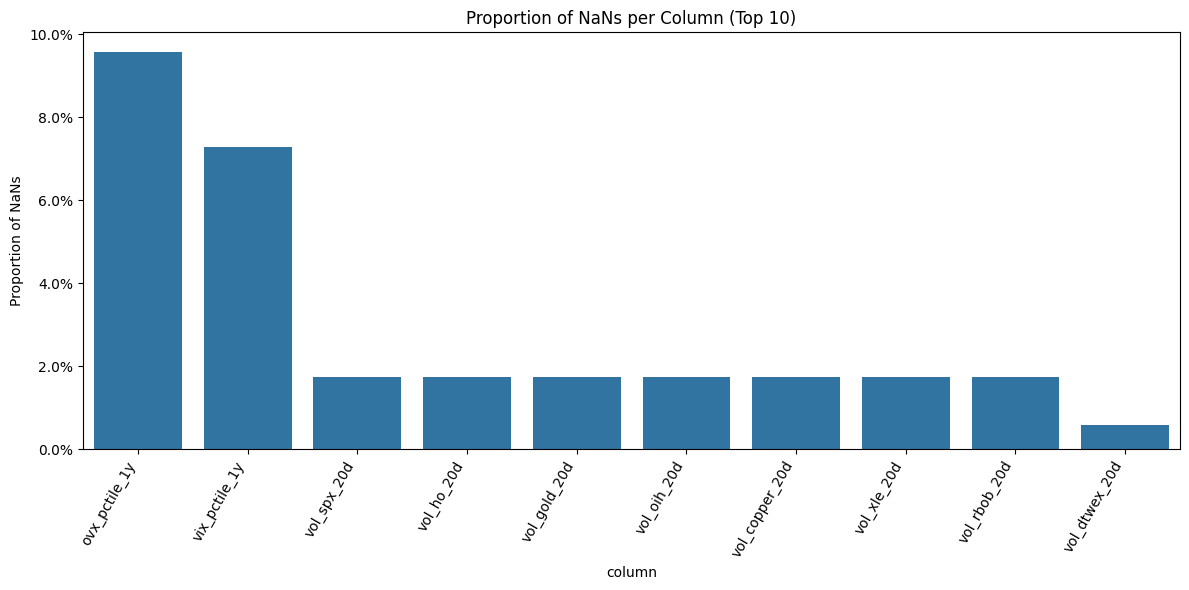

In [14]:
# NaN proportion per column
nan_props = df.isna().mean().sort_values(ascending=False)
print(nan_props)

if nan_props.max() == 0 or nan_props.empty:
    print("No NaNs found.")
else:
    top = nan_props.head(10).reset_index()
    top.columns = ["column", "nan_prop"]

    plt.figure(figsize=(12, 6))
    sns.barplot(data=top, x="column", y="nan_prop", color="C0")
    plt.xticks(rotation=60, ha="right")
    plt.ylabel("Proportion of NaNs")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
    plt.title("Proportion of NaNs per Column (Top 10)")
    plt.tight_layout()
    plt.show()

# Preprocessing & feature engineering 

In [15]:
df_model = df.copy()

# 2) Align training window to start after first 252 trading days
#    so vix_pctile_1y and ovx_pctile_1y are populated
req = ["vix_pctile_1y", "ovx_pctile_1y"]
have_req = [c for c in req if c in df_model.columns]
if len(have_req) == 2:
    first_full = df_model[have_req].dropna().index.min()
else:
    first_full = pd.NaT

if pd.isna(first_full):
    print("[WARN] Could not find first day with both ")

print("[INFO] Training start date:", first_full.date())
df_train = df_model.loc[first_full:].copy()

# 3) Quick NaN summary before/after
nan_props_all = df_model.isna().mean().sort_values(ascending=False)
nan_props_train = df_train.isna().mean().sort_values(ascending=False)

print("\n[INFO] Top 10 NaN proportions (full sample):")
print(nan_props_all.head(10))

print("\n[INFO] Top 10 NaN proportions (training window):")
print(nan_props_train.head(10))

print("\n[INFO] Shapes -> full:", df_model.shape, "training:", df_train.shape)

[INFO] Training start date: 2013-01-03

[INFO] Top 10 NaN proportions (full sample):
ovx_pctile_1y     0.095680
vix_pctile_1y     0.072775
vol_spx_20d       0.017396
vol_ho_20d        0.017396
vol_gold_20d      0.017396
vol_oih_20d       0.017396
vol_copper_20d    0.017396
vol_xle_20d       0.017396
vol_rbob_20d      0.017396
vol_dtwex_20d     0.005799
dtype: float64

[INFO] Top 10 NaN proportions (training window):
ovx_pctile_1y     0.024703
vol_xle_20d       0.012508
vol_gold_20d      0.012508
vol_copper_20d    0.012508
vol_spx_20d       0.012508
vol_ho_20d        0.012508
vol_rbob_20d      0.012508
vol_oih_20d       0.012508
vol_spx_5d        0.004065
ret_oih           0.001563
dtype: float64

[INFO] Shapes -> full: (3449, 45) training: (3198, 45)


# Modeling

In [16]:
df_modeling = df_train.copy() if "df_train" in globals() else df.copy()

# Targets
df_modeling["y_price_next"] = df_modeling["wti_price"].shift(-1)
df_modeling["y_up_next"] = (
    df_modeling["wti_price"].shift(-1) > df_modeling["wti_price"]
).astype("float64")

all_nan_cols = df_modeling.columns[df_modeling.isna().all()].tolist()
if all_nan_cols:
    print("[WARN] Dropping all-NaN columns:", all_nan_cols)
    df_modeling = df_modeling.drop(columns=all_nan_cols)

# Drop rows with any NaN across features and targets
before_rows = len(df_modeling)
df_modeling = df_modeling.dropna(how="any")
after_rows = len(df_modeling)
print(
    f"[INFO] Dropped {before_rows - after_rows} rows with NaNs. "
    f"Remaining rows: {after_rows}"
)

[INFO] Dropped 79 rows with NaNs. Remaining rows: 3119


In [17]:
print("[INFO] Date range:", df_modeling.index.min().date(), "->", df_modeling.index.max().date())
print("[INFO] Columns:", len(df_modeling.columns))
print("[INFO] Target preview (y_price_next, y_up_next):")
print(df_modeling[["y_price_next", "y_up_next"]].head(3))

[INFO] Date range: 2013-01-03 -> 2025-05-23
[INFO] Columns: 47
[INFO] Target preview (y_price_next, y_up_next):
            y_price_next  y_up_next
Date                               
2013-01-03     93.089996        1.0
2013-01-04     93.190002        1.0
2013-01-07     93.150002        0.0


In [18]:
SPLIT_FRAC = 0.85  
n_total = len(df_modeling)
n_train = int(np.floor(n_total * SPLIT_FRAC))


feature_cols = [c for c in df_modeling.columns if c not in ("y_price_next", "y_up_next")]
X = df_modeling[feature_cols]
y_reg = df_modeling["y_price_next"]
y_cls = df_modeling["y_up_next"]

X_train, X_test = X.iloc[:n_train], X.iloc[n_train:]
y_reg_train, y_reg_test = y_reg.iloc[:n_train], y_reg.iloc[n_train:]
y_cls_train, y_cls_test = y_cls.iloc[:n_train], y_cls.iloc[n_train:]

print(
    f"[INFO] Split -> train: {X_train.shape}, test: {X_test.shape} "
    f"(frac={SPLIT_FRAC:.2f})"
)
print(
    "[INFO] Train dates:",
    X_train.index.min().date(),
    "->",
    X_train.index.max().date(),
)
print(
    "[INFO] Test dates:",
    X_test.index.min().date(),
    "->",
    X_test.index.max().date(),
)

[INFO] Split -> train: (2651, 45), test: (468, 45) (frac=0.85)
[INFO] Train dates: 2013-01-03 -> 2023-07-17
[INFO] Test dates: 2023-07-18 -> 2025-05-23


In [19]:
assert X_train.index.is_monotonic_increasing and X_test.index.is_monotonic_increasing
assert X_train.index[-1] < X_test.index[0], "Time split should not overlap"